# Adversarial Robustness toolbox (ART) example

The script demonstrates a simple example of using ART with TensorFlow v2.x. The example train a small model on the MNIST
dataset and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train
the model, it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.

* reference: https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_tensorflow_v2.py

### Image Classification

* Date: 24/10/2024
* Author: Pankaj Maurya
* Type of attack: ART tool attack (FGSM)

### Metadata
* Dataset: MNIST
* Size of training set:60,000
* Size of testing set : 10,000
* Number of class : 10
* Original Model: CNN model trained with ART classifier

In [ ]:
"""
Description: Uncomment and run to install libraries. Needed for running first time only.
"""
!pip install adversarial-robustness-toolbox
!pip install tensorflow==2.10
!pip install matplotlib==3.8.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 40.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-se

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 98.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


In [ ]:
"""
Description: import library
"""
import numpy as np
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
from art.utils import load_mnist

import random
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load the MNIST dataset

In [ ]:
"""
Description: Load mnist data with art functionality.
"""
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [ ]:
'''
New Block: Additional block added for creating function for visualization of images
Description: visualize sample images.
'''
def plot_images(x_train, y_train=None, rows=3):
    #visualize x_train and y_train
    ROWS=rows
    random_indices=random.sample(range(x_train.shape[0]),ROWS*ROWS)
    # print("the random indices are: ", random_indices)

    #taking sample image from x_train dataset
    sample_images=x_train[random_indices,: ]
    if y_train is not None:
        sample_label=y_train[random_indices]
    else:
        sample_label = [999999]*x_train.shape[0]


    fig,ax=plt.subplots(nrows=ROWS,ncols=ROWS,figsize=(12,9),sharex=True,sharey=True)
    for i in range(ROWS*ROWS):
        subplot_row=i // ROWS
        subplot_col=i % ROWS
        ax[subplot_row,subplot_col].imshow(sample_images[i,:]) #,cmap='gray_r'
        ax[subplot_row,subplot_col].set_title("No. %d" % sample_label[i])
    plt.tight_layout()

In [ ]:
"""
New Block: check shape of image and label after loading. label are one hot encoded
Description: check shape of traing and label data
"""
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

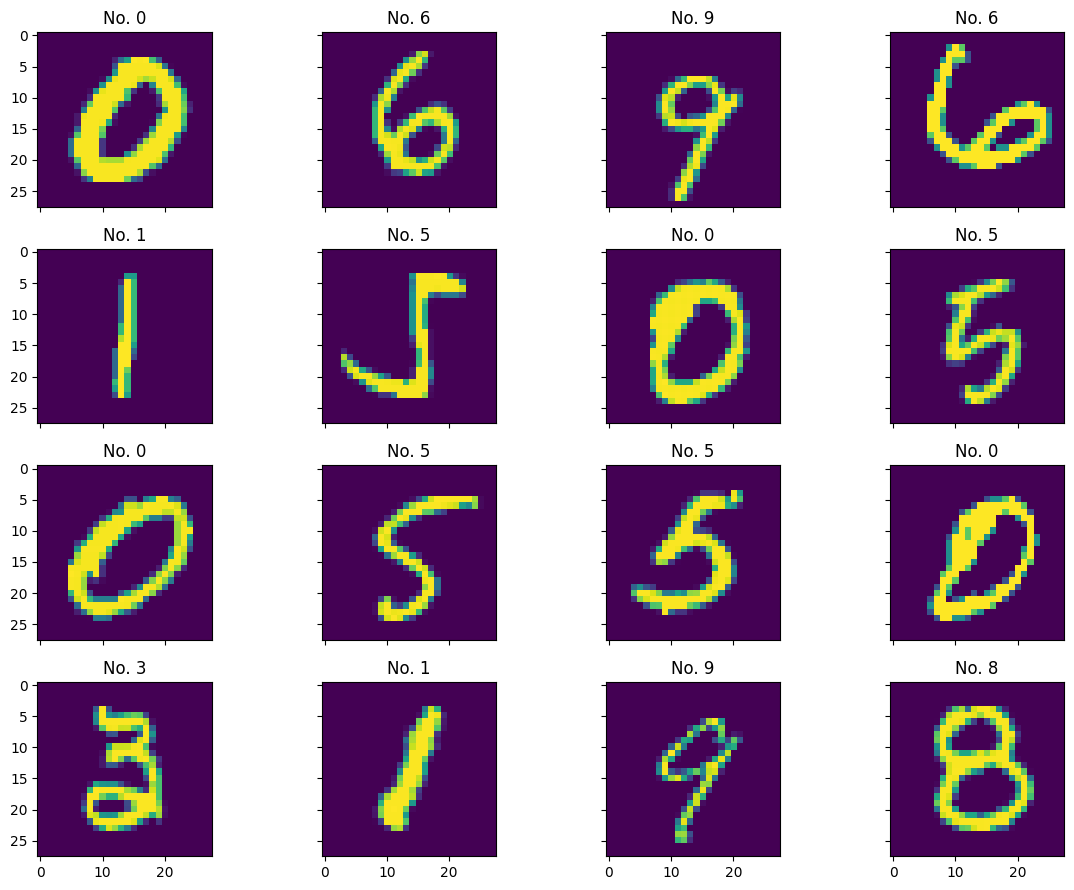

In [ ]:
'''
New Block: convert label from one hot encoder. it will randomly plot rows * rows labels with labels.
Description: visualize few training dataset
'''
plot_images(x_train, np.argmax(y_train, axis=-1), rows=4)

# Step 2: Create the model

In [ ]:
"""
Description: Import librabry for tensorflow model
"""
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D

In [ ]:
"""
Description: create class to design architecture of model
"""
class TensorFlowModel(Model):
    """
    Standard TensorFlow model for unit testing.
    """

    def __init__(self):
        super(TensorFlowModel, self).__init__()
        self.conv1 = Conv2D(filters=4, kernel_size=5, activation="relu")
        self.conv2 = Conv2D(filters=10, kernel_size=5, activation="relu")
        self.maxpool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="valid", data_format=None)
        self.flatten = Flatten()
        self.dense1 = Dense(100, activation="relu")
        self.logits = Dense(10, activation="linear")

    def call(self, x):
        """
        Call function to evaluate the model.

        :param x: Input to the model
        :return: Prediction of the model
        """
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.logits(x)
        return x


In [ ]:
"""
Description: Create architecture of model.
"""
model = TensorFlowModel()

In [ ]:
"""
Description: Create loss object for model.
"""
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
"""
Description: create optimizer
"""
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# Step 3: Create the ART classifier

In [ ]:
"""
Description: create classifier with art library
"""
classifier = TensorFlowV2Classifier(
    model=model,
    loss_object=loss_object,
    optimizer=optimizer,
    nb_classes=10,
    input_shape=(28, 28, 1),
    clip_values=(0, 1),
)


# Step 4: Train the ART classifier

In [ ]:
"""
Description: train classifier.
"""
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=5)

# Step 5: Evaluate the ART classifier on benign test examples

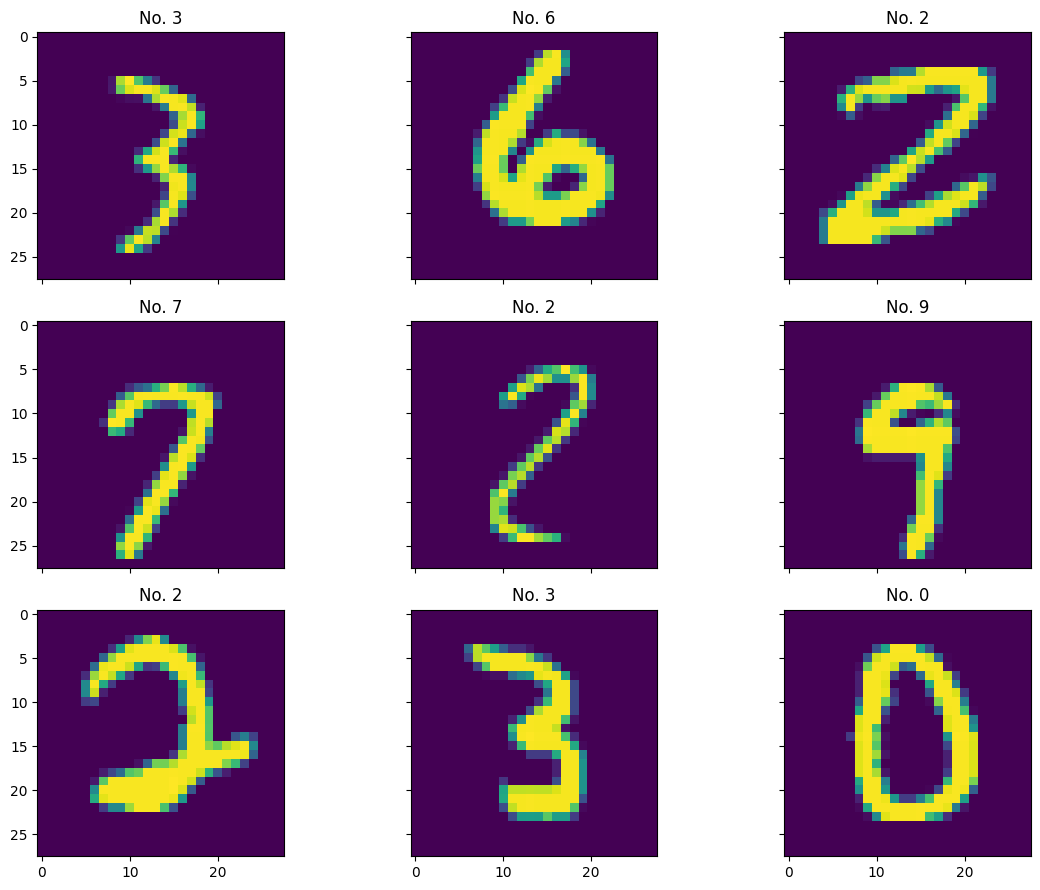

In [ ]:
'''
New Block: convert label from one hot encoder. it will randomly plot rows * rows labels with labels.
Description: visualize few testing dataset
'''
plot_images(x_test, np.argmax(y_test, axis=-1), rows=3)

In [ ]:
"""
Description: check accuracy on test data
"""
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 98.24000000000001%


# Step 6: Generate adversarial test examples

In [ ]:
"""
Description: Create adversarial sample with FGSM methods
"""
attack = FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)
x_test_adv.shape

(10000, 28, 28, 1)

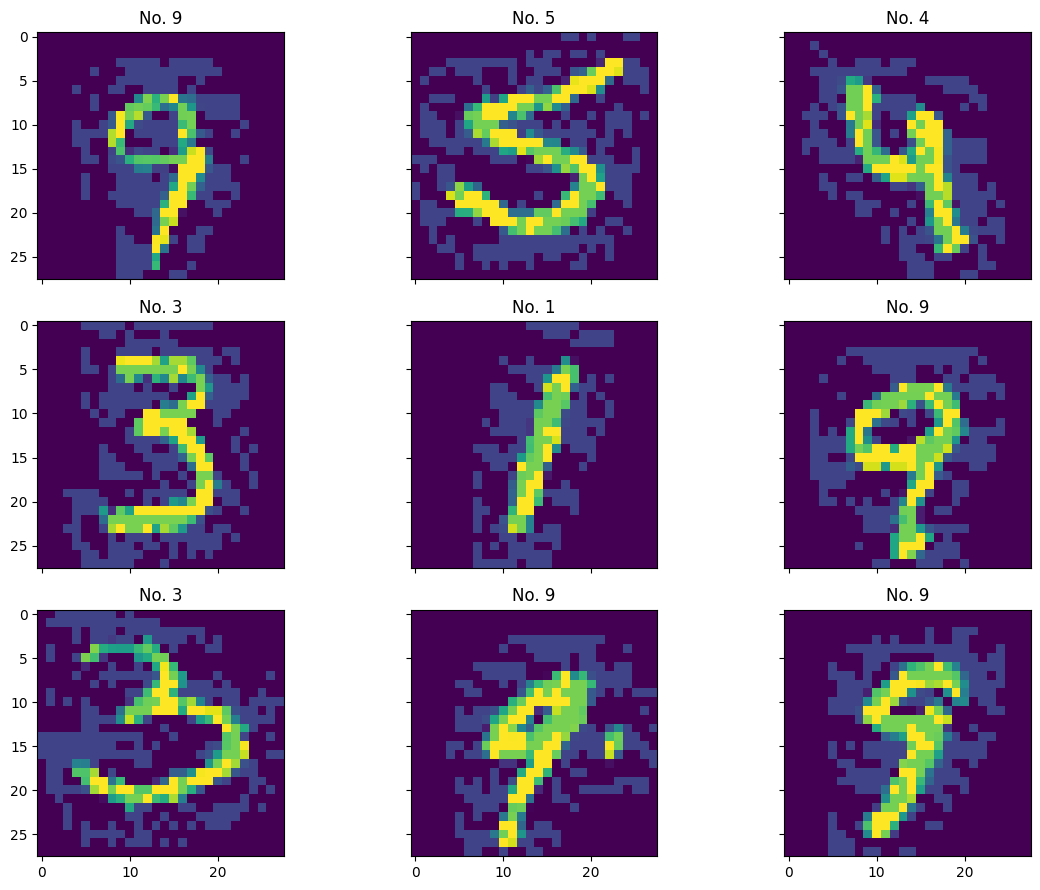

In [ ]:
'''
New Block: convert label from one hot encoder. it will randomly plot rows * rows labels with labels.
Description: visualize few testing dataset
'''
plot_images(x_test_adv, np.argmax(y_test, axis=-1), rows=3)

# Step 7: Evaluate the ART classifier on adversarial test examples

In [ ]:
"""
Description: check accuracy of model on adversarial sample.
"""
adv_predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(adv_predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 54.900000000000006%


# Additional Steps

In [ ]:
"""
Description: Select successful adversarial sample. Prediction that is different from true label
"""
adv_x = []
adx_label = []
for i, img in enumerate(x_test_adv):
    if np.argmax(predictions[i],axis=-1)!=np.argmax(adv_predictions[i], axis=-1):
        adv_x.append(img)
        adx_label.append(np.argmax(adv_predictions[i], axis=-1))


In [ ]:
"""
Description: Print to check successfull adversarial sample
"""
print("Successful adversarial sample : {}/{}".format(len(adv_x), len(x_test)))

Successful adversarial sample : 4632/10000


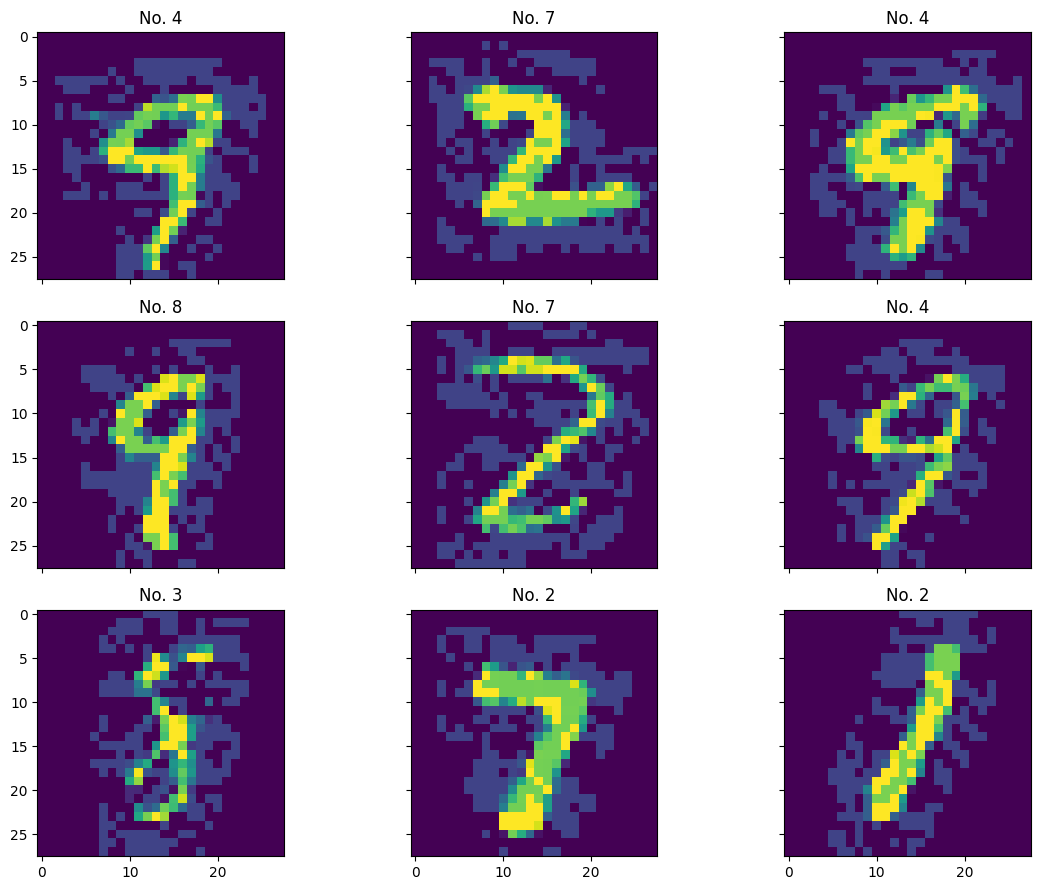

In [ ]:
'''
Description: visualize few advesarial dataset. label are from model on adversarial sample
'''
plot_images(np.array(adv_x), np.array(adx_label), rows=3)